In [1]:
!pip install bayesian-optimization
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=1f82710a49932ae0849192536ed588edf393ebab2b87703640600c9c98ecf494
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [2]:
import os
from google.colab import drive

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
import psutil
import GPUtil

from bayes_opt import BayesianOptimization

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

device

device(type='cuda')

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
X = np.load("/content/drive/MyDrive/Parkinson/X.npy")
y = np.load("/content/drive/MyDrive/Parkinson/y.npy")
y_multi_class = np.nan_to_num(np.load("/content/drive/MyDrive/Parkinson/y_multi_class.npy"))

X.shape, y.shape

((44021, 100, 19), (44021,))

In [40]:
# categorize the data
y_cat = np.eye(np.unique(y).shape[0], dtype='uint8')[y]
y_multi_class_cat = np.eye(np.unique(y_multi_class).shape[0], dtype='uint8')[np.asarray(y_multi_class, dtype='uint8')]

# split the data into train, validation and test sets using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y_multi_class_cat, shuffle=True, test_size=0.33)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, shuffle=True, test_size=0.5)

# display the shape of the train, validation and test sets
print("Shape of the train set: ", X_train.shape)
print("Shape of the validation set: ", X_val.shape)
print("Shape of the test set: ", X_test.shape)

# display the shape of the train, validation and test sets
print("Shape of the train set: ", y_train.shape)
print("Shape of the validation set: ", y_val.shape)
print("Shape of the test set: ", y_test.shape)

Shape of the train set:  (29494, 100, 19)
Shape of the validation set:  (7264, 100, 19)
Shape of the test set:  (7263, 100, 19)
Shape of the train set:  (29494, 4)
Shape of the validation set:  (7264, 4)
Shape of the test set:  (7263, 4)


In [41]:
X_train_tensors = Variable(torch.Tensor(X_train)).to(device)
X_val_tensors = Variable(torch.Tensor(X_val)).to(device)
X_test_tensors = Variable(torch.Tensor(X_test)).to(device)

y_train_tensors = Variable(torch.Tensor(y_train)).to(device)
y_test_tensors = Variable(torch.Tensor(y_test)).to(device)
y_val_tensors = Variable(torch.Tensor(y_val)).to(device)

X_train_tensors.shape, X_val_tensors.shape, X_test_tensors.shape, y_train_tensors.shape, y_val_tensors.shape, y_test_tensors.shape

(torch.Size([29494, 100, 19]),
 torch.Size([7264, 100, 19]),
 torch.Size([7263, 100, 19]),
 torch.Size([29494, 4]),
 torch.Size([7264, 4]),
 torch.Size([7263, 4]))

In [42]:
train_dataset = TensorDataset(X_train_tensors, y_train_tensors)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val_tensors, y_val_tensors)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensors, y_test_tensors)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [11]:
class GruModel(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size_gru, hidden_size_fc, num_layers, seq_length):
      super(GruModel, self).__init__()
      self.num_classes = num_classes
      self.num_layers = num_layers
      self.input_size = input_size
      self.hidden_size_gru = hidden_size_gru
      self.hidden_size_fc = hidden_size_fc
      self.seq_length = seq_length

      self.gru_1 = nn.GRU(input_size=input_size, hidden_size=hidden_size_gru,
                        num_layers=num_layers, batch_first=True)
      self.gru_2 = nn.GRU(input_size=hidden_size_gru, hidden_size=hidden_size_gru//2,
                        num_layers=num_layers, batch_first=True)
      self.gru_3 = nn.GRU(input_size=hidden_size_gru//2, hidden_size=hidden_size_gru//4,
                        num_layers=num_layers, batch_first=True)
      self.gru_4 = nn.GRU(input_size=hidden_size_gru//4, hidden_size=hidden_size_gru//8,
                        num_layers=num_layers, batch_first=True)

      self.fc_1 =  nn.Linear(hidden_size_gru//8, hidden_size_fc)
      self.fc_2 =  nn.Linear(hidden_size_fc, hidden_size_fc//2)
      self.fc = nn.Linear(hidden_size_fc//2, num_classes)

      self.tanh = nn.Tanh()
      self.elu = nn.ELU()

      self.dp = nn.Dropout(p=0.3)

      self.counter = 0
      self.min_validation_loss = float('inf')

  def forward(self,x):

      output, _ = self.gru_1(x)
      output = self.tanh(output)

      output, _ = self.gru_2(output)
      output = self.tanh(output)

      output, _ = self.gru_3(output)
      output = self.tanh(output)

      output, _ = self.gru_4(output)
      output = self.tanh(output)

      output = output[:, -1, :]

      out = self.fc_1(output)
      out = self.elu(out)
      out = self.dp(out)
      out = self.fc_2(out)
      out = self.elu(out)
      out = self.dp(out)
      out = self.fc(out)

      return out

  def early_stop(self, validation_loss, min_delta, patience):
    if validation_loss < self.min_validation_loss:
        self.min_validation_loss = validation_loss
        self.counter = 0
    elif validation_loss > (self.min_validation_loss + min_delta):
        self.counter += 1
        if self.counter >= patience:
            return True
    return False

In [ ]:
def gru_training(p1, p2, p3, p4):
  gru_model = GruModel(4, 19, int(p1), int(p2), 1, p3, X_train_tensors.shape[1]).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(gru_model.parameters(), lr=p4)


  history = {"loss":[], "accuracy":[], "val_loss":[], "val_accuracy":[]}

  best_acc = 0

  for epoch in range(100):
    batch_train_acc = []
    batch_train_loss = []
    for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):
      gru_model.train()
      outputs = gru_model.forward(x_batch)
      optimizer.zero_grad()

      loss = criterion(outputs, y_batch)

      loss.backward()

      optimizer.step()

      batch_train_loss.append(loss.item())

      _, predicted = torch.max(outputs, 1)

      correct = torch.eq(torch.max(y_batch, 1)[1], predicted).sum().item()
      total = y_batch.size(0)
      batch_train_acc.append(correct / total)


    epoch_loss = np.average(batch_train_loss)
    history["loss"].append(epoch_loss)
    accuracy = np.average(batch_train_acc)
    history["accuracy"].append(accuracy)

    with torch.no_grad():
      batch_val_acc = []
      batch_val_loss = []
      for id_batch, (x_batch, y_batch) in enumerate(val_dataloader):
        gru_model.eval()
        val_outputs = gru_model(x_batch)
        val_loss = criterion(val_outputs, y_batch)

        batch_val_loss.append(val_loss.item())

        _, val_predicted = torch.max(val_outputs, 1)
        val_correct = torch.eq(torch.max(y_batch, 1)[1], val_predicted).sum().item()
        val_total = y_batch.size(0)
        batch_val_acc.append(val_correct / val_total)

      epoch_val_loss = np.average(batch_val_loss)
      history["val_loss"].append(epoch_val_loss)
      val_accuracy = np.average(batch_val_acc)
      history["val_accuracy"].append(val_accuracy)

    if best_acc < val_accuracy:
      best_acc = val_accuracy

    if gru_model.early_stop(validation_loss=epoch_val_loss, min_delta=0, patience=5):
      break

  return best_acc

In [ ]:
def cma_es(objective_function, initial_solution, population_size=10, max_generations=10):

    """
    Algorithme CMA-ES pour l'optimisation continue

    Args:
        objective_function: Fonction objectif à minimiser
        initial_solution: Solution initiale
        population_size: Taille de la population
        max_generations: Nombre maximum de générations

    Returns:
        Meilleure solution trouvée
        Meilleure valeur de fitness
        Liste des meilleures valeurs de fitness à chaque génération
        Liste des solutions à chaque génération
    """

    # Définir la dimension du problème
    n = len(initial_solution)

    # Paramètres de l'algorithme CMA-ES
    sigma = 1.0  # Écart-type initial
    mu = population_size // 2  # Taille de la moitié de la population
    lambda_ = population_size  # Taille de la population

    # Listes pour stocker les résultats
    best_fitness_list = []
    current_solution = initial_solution
    current_sigma = sigma
    solution_list = []

    # Itérer sur les générations
    for generation in range(max_generations):

        # Générer une population de solutions candidates
        solutions = np.abs(np.random.multivariate_normal(current_solution, current_sigma**2 * np.identity(n), lambda_))

        # S'assurer que les solutions généré respectent les intervalles
        solutions[solutions[:, 0] < 256, 0] = 2 - solutions[solutions[:, 0] < 256, 0]

        solutions[solutions[:, 0] > 1024, 0] = solutions[solutions[:, 0] > 1024, 0] - (solutions[solutions[:, 0] > 1024, 0] / 1024).astype(int) * 1024

        solutions[solutions[:, 1] < 128, 1] = 2 * 128 - solutions[solutions[:, 1] < 128, 1]

        solutions[solutions[:, 1] > 1024, 1] = solutions[solutions[:, 1] > 1024, 1] - (solutions[solutions[:, 1] > 1024, 1] / 1024).astype(int) * 1024

        solutions[solutions[:, 2] < 0.1, 2] = 2 - solutions[solutions[:, 2] < 0.1, 2]

        solutions[solutions[:, 2] > 0.5, 2] = solutions[solutions[:, 2] > 0.5, 2] - (solutions[solutions[:, 2] > 0.5, 2] / 0.5).astype(int) * 0.5

        solutions[solutions[:, 3] < 0.0001, 3] = 2 * 0.0001 - solutions[solutions[:, 3] < 0.0001, 3]

        solutions[solutions[:, 3] > 0.01, 3] = solutions[solutions[:, 3] > 0.01, 3] - (solutions[solutions[:, 3] > 0.01, 3] / 0.01).astype(int) * 0.01


        # Évaluer la fitness de chaque solution
        fitness_values = np.array([objective_function(sol) for sol in solutions])

        # Trier les solutions par fitness
        sorted_indices = (-fitness_values).argsort()
        solutions = solutions[sorted_indices]

        # Mettre à jour la moyenne des meilleures solutions
        new_mean = np.mean(solutions[:mu], axis=0)
        current_solution = new_mean

        # Mettre à jour l'écart-type
        z = solutions[:mu] - current_solution
        current_sigma = np.sqrt(np.sum(z**2) / mu)

        # Afficher la meilleure solution à chaque génération
        best_fitness = fitness_values[sorted_indices[0]]

        # Stocker les résultats
        best_fitness_list.append(best_fitness)
        solution_list.append(current_solution[0])

    return current_solution, best_fitness

In [51]:
best_solution, best_fitness = cma_es(objective_function=gru_training, initial_solution=[256, 512, 0.3, 0.001], population_size=10, max_generations=10)
print(f'hidden_size_l = {int(best_solution[0])}, hidden_size_f = {int(best_solution[1])}, dropout = {best_solution[2]}, learning_rate = {best_solution[3]:.4f}')
print(f'target = {best_fitness}')

hidden_size_l = 128, hidden_size_f = 256, dropout = 0.3, learning_rate = 0.0010
target = 0.9704


In [48]:
num_epochs = 100
learning_rate = 0.001

input_size = 19
hidden_size_l = 128
hidden_size_f = 256
dropout = 0.3
num_layers = 1

num_classes = 4

In [33]:
gru_model = GruModel(num_classes, input_size, hidden_size_l, hidden_size_f, num_layers, X_train_tensors.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)


history = {"loss":[], "accuracy":[], "val_loss":[], "val_accuracy":[]}

best_acc = 0

# Get GPU usage before running your code
if len(GPUtil.getGPUs()) != 0:
  start_gpu_usage = GPUtil.getGPUs()[0].load * 100

# Get CPU and Memory usage before running your code
start_memory_usage = psutil.virtual_memory().percent
start_cpu_usage = psutil.cpu_percent()

import time
start_time = time.time()

print("----------------------------------------------------------------------------------------------")

for epoch in range(num_epochs):
  batch_train_acc = []
  batch_train_loss = []
  with tqdm(total=len(train_dataloader), desc = 'Training batch') as pbar:
    for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):
      gru_model.train()
      outputs = gru_model.forward(x_batch)
      optimizer.zero_grad()

      loss = criterion(outputs, y_batch)

      loss.backward()

      optimizer.step()

      batch_train_loss.append(loss.item())

      _, predicted = torch.max(outputs, 1)

      correct = torch.eq(torch.max(y_batch, 1)[1], predicted).sum().item()
      total = y_batch.size(0)
      batch_train_acc.append(correct / total)

      pbar.update(1)

  epoch_loss = np.average(batch_train_loss)
  history["loss"].append(epoch_loss)
  accuracy = np.average(batch_train_acc)
  history["accuracy"].append(accuracy)

  with torch.no_grad():
    batch_val_acc = []
    batch_val_loss = []
    with tqdm(total=len(val_dataloader), desc = 'Validation batch') as pbar:
      for id_batch, (x_batch, y_batch) in enumerate(val_dataloader):
        gru_model.eval()
        val_outputs = gru_model(x_batch)
        val_loss = criterion(val_outputs, y_batch)

        batch_val_loss.append(val_loss.item())

        _, val_predicted = torch.max(val_outputs, 1)
        val_correct = torch.eq(torch.max(y_batch, 1)[1], val_predicted).sum().item()
        val_total = y_batch.size(0)
        batch_val_acc.append(val_correct / val_total)

        pbar.update(1)

    epoch_val_loss = np.average(batch_val_loss)
    history["val_loss"].append(epoch_val_loss)
    val_accuracy = np.average(batch_val_acc)
    history["val_accuracy"].append(val_accuracy)

  print("Epoch: %d, Loss: %1.5f, Accuracy: %1.5f, Val Loss: %1.5f, Val Accuracy: %1.5f" % (epoch+1, epoch_loss, accuracy, epoch_val_loss, val_accuracy))
  print("----------------------------------------------------------------------------------------------")

  if best_acc < val_accuracy:
    best_acc = val_accuracy
    torch.save(gru_model.state_dict(), f"best_model.pth")
  if gru_model.early_stop(validation_loss=epoch_val_loss, min_delta=0, patience=5):
    break

execution_time = time.time() - start_time

# Get CPU and Memory usage after running your code
end_cpu_usage = psutil.cpu_percent()
end_memory_usage = psutil.virtual_memory().percent
# Get GPU usage after running your code
if len(GPUtil.getGPUs()) != 0:
  end_gpu_usage = GPUtil.getGPUs()[0].load * 100

----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.41636, Accuracy: 0.82194, Val Loss: 0.35796, Val Accuracy: 0.85118
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.34288, Accuracy: 0.86038, Val Loss: 0.38637, Val Accuracy: 0.82792
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.30657, Accuracy: 0.87644, Val Loss: 0.29627, Val Accuracy: 0.87596
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.27906, Accuracy: 0.88622, Val Loss: 0.27449, Val Accuracy: 0.88794
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.24866, Accuracy: 0.90100, Val Loss: 0.23554, Val Accuracy: 0.90556
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.23562, Accuracy: 0.90548, Val Loss: 0.22086, Val Accuracy: 0.91093
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.21220, Accuracy: 0.91556, Val Loss: 0.21562, Val Accuracy: 0.91754
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.19671, Accuracy: 0.92350, Val Loss: 0.17828, Val Accuracy: 0.93406
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.17347, Accuracy: 0.93379, Val Loss: 0.18324, Val Accuracy: 0.92483
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.17691, Accuracy: 0.93153, Val Loss: 0.16598, Val Accuracy: 0.93433
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.16770, Accuracy: 0.93552, Val Loss: 0.15745, Val Accuracy: 0.93970
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.15431, Accuracy: 0.93992, Val Loss: 0.17260, Val Accuracy: 0.93433
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 13, Loss: 0.15323, Accuracy: 0.94172, Val Loss: 0.16261, Val Accuracy: 0.94025
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 14, Loss: 0.14613, Accuracy: 0.94505, Val Loss: 0.14356, Val Accuracy: 0.94411
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.13266, Accuracy: 0.95030, Val Loss: 0.15000, Val Accuracy: 0.94314
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 16, Loss: 0.13554, Accuracy: 0.94864, Val Loss: 0.16379, Val Accuracy: 0.93530
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 17, Loss: 0.13188, Accuracy: 0.95001, Val Loss: 0.13991, Val Accuracy: 0.94838
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 18, Loss: 0.12513, Accuracy: 0.95230, Val Loss: 0.12540, Val Accuracy: 0.95471
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.11702, Accuracy: 0.95475, Val Loss: 0.14672, Val Accuracy: 0.94342
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 20, Loss: 0.12072, Accuracy: 0.95353, Val Loss: 0.13826, Val Accuracy: 0.94672
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 21, Loss: 0.11034, Accuracy: 0.95738, Val Loss: 0.14485, Val Accuracy: 0.94369
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 22, Loss: 0.10834, Accuracy: 0.95799, Val Loss: 0.12789, Val Accuracy: 0.95485
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 23, Loss: 0.10478, Accuracy: 0.96021, Val Loss: 0.11906, Val Accuracy: 0.95512
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 24, Loss: 0.11082, Accuracy: 0.95713, Val Loss: 0.12648, Val Accuracy: 0.94906
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 25, Loss: 0.09913, Accuracy: 0.96347, Val Loss: 0.11774, Val Accuracy: 0.95292
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 26, Loss: 0.10082, Accuracy: 0.96189, Val Loss: 0.13684, Val Accuracy: 0.95085
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 27, Loss: 0.10510, Accuracy: 0.96040, Val Loss: 0.11329, Val Accuracy: 0.95705
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 28, Loss: 0.09610, Accuracy: 0.96284, Val Loss: 0.11497, Val Accuracy: 0.95457
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 29, Loss: 0.09460, Accuracy: 0.96399, Val Loss: 0.10979, Val Accuracy: 0.95843
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 30, Loss: 0.09447, Accuracy: 0.96379, Val Loss: 0.11206, Val Accuracy: 0.95732
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 31, Loss: 0.09203, Accuracy: 0.96496, Val Loss: 0.10757, Val Accuracy: 0.95856
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 32, Loss: 0.08396, Accuracy: 0.96746, Val Loss: 0.11026, Val Accuracy: 0.96049
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 33, Loss: 0.08883, Accuracy: 0.96643, Val Loss: 0.12506, Val Accuracy: 0.95306
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 34, Loss: 0.08355, Accuracy: 0.96802, Val Loss: 0.11160, Val Accuracy: 0.96173
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 35, Loss: 0.09208, Accuracy: 0.96531, Val Loss: 0.09632, Val Accuracy: 0.96407
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 36, Loss: 0.08444, Accuracy: 0.96790, Val Loss: 0.10151, Val Accuracy: 0.96173
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 37, Loss: 0.08020, Accuracy: 0.96824, Val Loss: 0.09614, Val Accuracy: 0.96448
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 38, Loss: 0.07977, Accuracy: 0.96990, Val Loss: 0.13120, Val Accuracy: 0.95278
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 39, Loss: 0.07743, Accuracy: 0.96979, Val Loss: 0.09650, Val Accuracy: 0.96517
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 40, Loss: 0.07907, Accuracy: 0.96970, Val Loss: 0.10975, Val Accuracy: 0.96008
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 41, Loss: 0.07604, Accuracy: 0.96979, Val Loss: 0.09512, Val Accuracy: 0.96861
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 42, Loss: 0.07931, Accuracy: 0.96848, Val Loss: 0.10952, Val Accuracy: 0.96077
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 43, Loss: 0.06581, Accuracy: 0.97443, Val Loss: 0.10458, Val Accuracy: 0.96448
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 44, Loss: 0.08218, Accuracy: 0.96929, Val Loss: 0.12908, Val Accuracy: 0.95251
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 45, Loss: 0.07653, Accuracy: 0.97082, Val Loss: 0.11164, Val Accuracy: 0.96077
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 46, Loss: 0.07522, Accuracy: 0.97055, Val Loss: 0.09021, Val Accuracy: 0.96792
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 47, Loss: 0.07073, Accuracy: 0.97370, Val Loss: 0.09782, Val Accuracy: 0.96421
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 48, Loss: 0.06859, Accuracy: 0.97473, Val Loss: 0.08968, Val Accuracy: 0.97040
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 49, Loss: 0.07096, Accuracy: 0.97353, Val Loss: 0.10120, Val Accuracy: 0.96545
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 50, Loss: 0.06785, Accuracy: 0.97356, Val Loss: 0.08744, Val Accuracy: 0.96875
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 51, Loss: 0.06452, Accuracy: 0.97421, Val Loss: 0.13850, Val Accuracy: 0.95567
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 52, Loss: 0.06892, Accuracy: 0.97426, Val Loss: 0.12635, Val Accuracy: 0.95154
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 53, Loss: 0.06787, Accuracy: 0.97392, Val Loss: 0.10432, Val Accuracy: 0.96214
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 54, Loss: 0.06985, Accuracy: 0.97400, Val Loss: 0.09566, Val Accuracy: 0.96779
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 55, Loss: 0.06302, Accuracy: 0.97458, Val Loss: 0.11116, Val Accuracy: 0.96311
----------------------------------------------------------------------------------------------


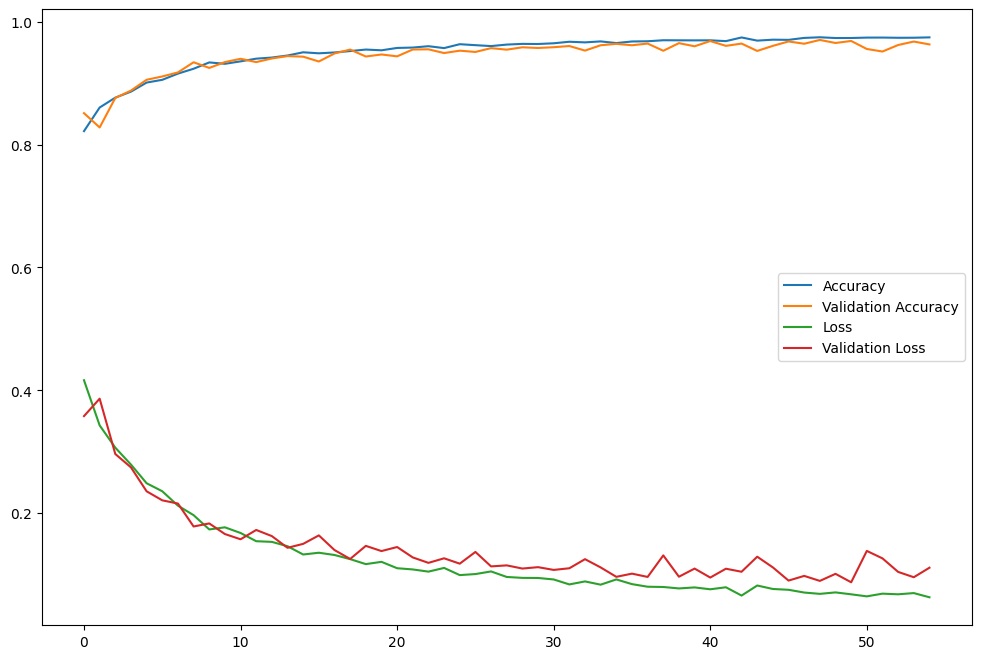

In [34]:
plt.figure(figsize=(12, 8))
plt.plot(history['accuracy'], label='Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.plot(history['loss'], label='Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()

In [36]:
gru_model.load_state_dict(torch.load("/content/best_model.pth"))

y_pred = []
y_real = []
with torch.no_grad():
    batch_test_acc = []
    with tqdm(total=len(test_dataloader), desc = 'Testing') as pbar:
      for id_batch, (x_batch, y_batch) in enumerate(test_dataloader):
        gru_model.eval()
        test_outputs = gru_model(x_batch)

        _, test_predicted = torch.max(test_outputs, 1)
        y_real.extend(torch.max(y_batch, 1)[1].cpu().data.numpy())
        y_pred.extend(test_predicted.cpu().data.numpy())
        test_correct = torch.eq(torch.max(y_batch, 1)[1], test_predicted).sum().item()
        test_total = y_batch.size(0)
        batch_test_acc.append(test_correct / test_total)
        pbar.update(1)

test_accuracy = np.average(batch_test_acc)

precision = precision_score(y_real, y_pred, average='weighted')
recall = recall_score(y_real, y_pred, average='weighted')
f1 = f1_score(y_real, y_pred, average='weighted')

cm = confusion_matrix(y_real, y_pred)

# Get the TP, TN, FP, FN values
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

macro_roc_auc_ovo = roc_auc_score(y_real, y_pred, multi_class="ovo", average="macro")

print(f'Loss: {history["val_loss"][-1]:.4f}')
print(f'Accuracy: {np.mean(test_accuracy):.4f}')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("TP:", TP.sum())
print("TN:", TN.sum())
print("FP:", FP.sum())
print("FN:", FN.sum())
print("AUC:", macro_roc_auc_ovo)
print(f"CPU Usage: {end_cpu_usage - start_cpu_usage}%")
print(f"Memory Usage: {end_memory_usage - start_memory_usage}%")
if len(GPUtil.getGPUs()) != 0: print(f"GPU Usage: {end_gpu_usage - start_gpu_usage}%")
print(f"Execution Time: {execution_time} seconds")

Testing:   0%|          | 0/227 [00:00<?, ?it/s]

Loss: 0.1112
Accuracy: 0.9653
Precision: 0.9651850416715444
Recall: 0.9653035935563816
F1 Score: 0.9651945158053181
TP: 7011
TN: 7011
FP: 252
FN: 252
AUC: 0.9558899182029547
CPU Usage: 53.49999999999999%
Memory Usage: -0.6000000000000014%
GPU Usage: 31.0%
Execution Time: 386.35463547706604 seconds


Text(0.5, 1.0, 'Confusion Matrix')

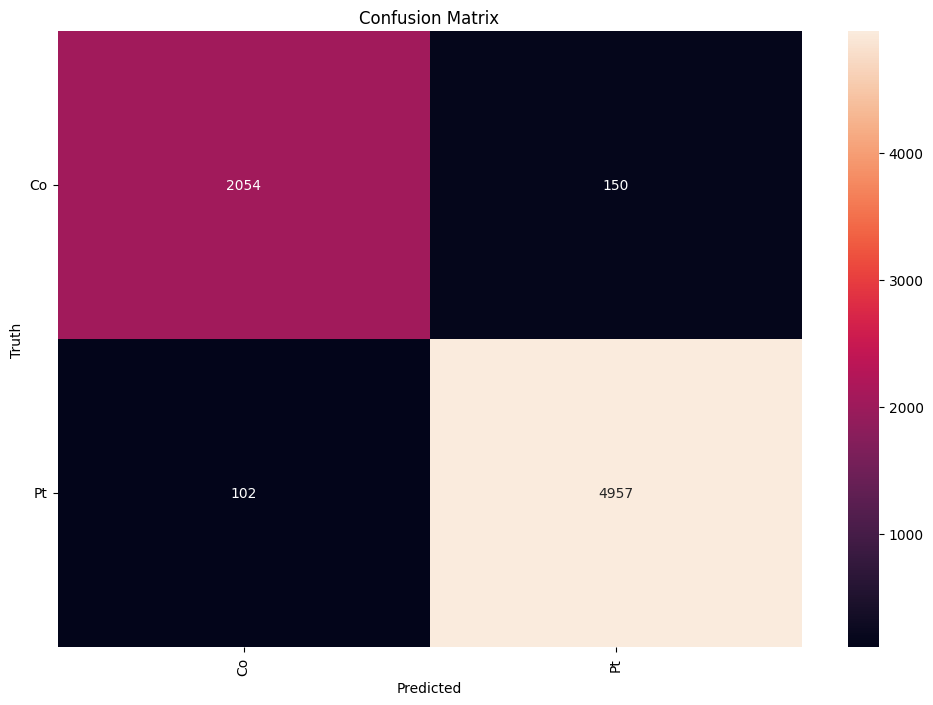

In [37]:
cm = confusion_matrix(y_real, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xticks(np.arange(2)+0.5, ['Co', 'Pt'], rotation=90)
plt.yticks(np.arange(2)+0.5, ['Co', 'Pt'], rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion Matrix")

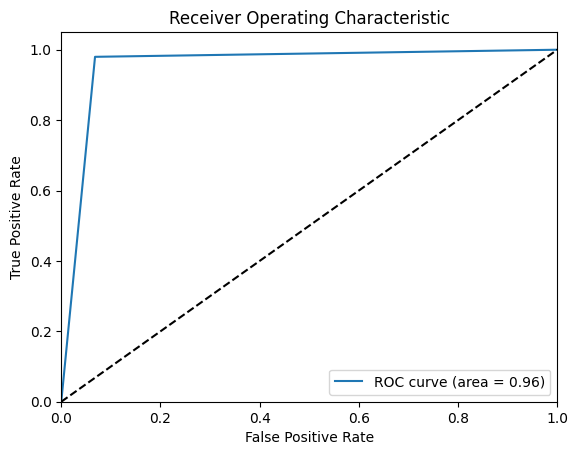

In [38]:
# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_real, y_pred)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [43]:
gru_model = GruModel(num_classes, input_size, hidden_size_l, hidden_size_f, num_layers, X_train_tensors.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)


history = {"loss":[], "accuracy":[], "val_loss":[], "val_accuracy":[]}

best_acc = 0

# Get GPU usage before running your code
if len(GPUtil.getGPUs()) != 0:
  start_gpu_usage = GPUtil.getGPUs()[0].load * 100

# Get CPU and Memory usage before running your code
start_memory_usage = psutil.virtual_memory().percent
start_cpu_usage = psutil.cpu_percent()

start_time = time.time()

print("----------------------------------------------------------------------------------------------")

for epoch in range(num_epochs):
  batch_train_acc = []
  batch_train_loss = []
  with tqdm(total=len(train_dataloader), desc = 'Training batch') as pbar:
    for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):
      gru_model.train()
      outputs = gru_model.forward(x_batch)
      optimizer.zero_grad()

      loss = criterion(outputs, y_batch)

      loss.backward()

      optimizer.step()

      batch_train_loss.append(loss.item())

      _, predicted = torch.max(outputs, 1)

      correct = torch.eq(torch.max(y_batch, 1)[1], predicted).sum().item()
      total = y_batch.size(0)
      batch_train_acc.append(correct / total)

      pbar.update(1)

  epoch_loss = np.average(batch_train_loss)
  history["loss"].append(epoch_loss)
  accuracy = np.average(batch_train_acc)
  history["accuracy"].append(accuracy)

  with torch.no_grad():
    batch_val_acc = []
    batch_val_loss = []
    with tqdm(total=len(val_dataloader), desc = 'Validation batch') as pbar:
      for id_batch, (x_batch, y_batch) in enumerate(val_dataloader):
        gru_model.eval()
        val_outputs = gru_model(x_batch)
        val_loss = criterion(val_outputs, y_batch)

        batch_val_loss.append(val_loss.item())

        _, val_predicted = torch.max(val_outputs, 1)
        val_correct = torch.eq(torch.max(y_batch, 1)[1], val_predicted).sum().item()
        val_total = y_batch.size(0)
        batch_val_acc.append(val_correct / val_total)

        pbar.update(1)

    epoch_val_loss = np.average(batch_val_loss)
    history["val_loss"].append(epoch_val_loss)
    val_accuracy = np.average(batch_val_acc)
    history["val_accuracy"].append(val_accuracy)

  print("Epoch: %d, Loss: %1.5f, Accuracy: %1.5f, Val Loss: %1.5f, Val Accuracy: %1.5f" % (epoch+1, epoch_loss, accuracy, epoch_val_loss, val_accuracy))
  print("----------------------------------------------------------------------------------------------")

  if best_acc < val_accuracy:
    best_acc = val_accuracy
    torch.save(gru_model.state_dict(), f"best_model.pth")
  if gru_model.early_stop(validation_loss=epoch_val_loss, min_delta=0, patience=5):
    break

execution_time = time.time() - start_time

# Get CPU and Memory usage after running your code
end_cpu_usage = psutil.cpu_percent()
end_memory_usage = psutil.virtual_memory().percent
# Get GPU usage after running your code
if len(GPUtil.getGPUs()) != 0:
  end_gpu_usage = GPUtil.getGPUs()[0].load * 100

----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.94720, Accuracy: 0.59841, Val Loss: 0.79942, Val Accuracy: 0.68172
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.72610, Accuracy: 0.71338, Val Loss: 0.69425, Val Accuracy: 0.73114
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.60179, Accuracy: 0.76519, Val Loss: 0.55009, Val Accuracy: 0.79598
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.50736, Accuracy: 0.80356, Val Loss: 0.49214, Val Accuracy: 0.80796
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.43647, Accuracy: 0.83250, Val Loss: 0.42096, Val Accuracy: 0.83590
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.39463, Accuracy: 0.84958, Val Loss: 0.38685, Val Accuracy: 0.84458
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.33505, Accuracy: 0.87212, Val Loss: 0.33188, Val Accuracy: 0.87555
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.29168, Accuracy: 0.88895, Val Loss: 0.26932, Val Accuracy: 0.89579
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.26941, Accuracy: 0.90012, Val Loss: 0.26453, Val Accuracy: 0.90074
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.25638, Accuracy: 0.90407, Val Loss: 0.25617, Val Accuracy: 0.90460
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.23966, Accuracy: 0.91164, Val Loss: 0.26143, Val Accuracy: 0.90721
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.22327, Accuracy: 0.91637, Val Loss: 0.29746, Val Accuracy: 0.88959
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 13, Loss: 0.21339, Accuracy: 0.92011, Val Loss: 0.27512, Val Accuracy: 0.89882
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 14, Loss: 0.19357, Accuracy: 0.92986, Val Loss: 0.22403, Val Accuracy: 0.91836
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.19125, Accuracy: 0.92796, Val Loss: 0.25551, Val Accuracy: 0.90639
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 16, Loss: 0.18790, Accuracy: 0.93142, Val Loss: 0.20393, Val Accuracy: 0.92249
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 17, Loss: 0.16636, Accuracy: 0.93922, Val Loss: 0.21229, Val Accuracy: 0.92222
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 18, Loss: 0.17003, Accuracy: 0.93738, Val Loss: 0.16850, Val Accuracy: 0.93420
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.16571, Accuracy: 0.93823, Val Loss: 0.18228, Val Accuracy: 0.93089
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 20, Loss: 0.15458, Accuracy: 0.94438, Val Loss: 0.16331, Val Accuracy: 0.94012
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 21, Loss: 0.15788, Accuracy: 0.94109, Val Loss: 0.18502, Val Accuracy: 0.93323
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 22, Loss: 0.15890, Accuracy: 0.94155, Val Loss: 0.21846, Val Accuracy: 0.91864
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 23, Loss: 0.14428, Accuracy: 0.94611, Val Loss: 0.16942, Val Accuracy: 0.93654
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 24, Loss: 0.13530, Accuracy: 0.94982, Val Loss: 0.16643, Val Accuracy: 0.94191
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 25, Loss: 0.13180, Accuracy: 0.95111, Val Loss: 0.15236, Val Accuracy: 0.94108
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 26, Loss: 0.12951, Accuracy: 0.95279, Val Loss: 0.17085, Val Accuracy: 0.93901
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 27, Loss: 0.13390, Accuracy: 0.95023, Val Loss: 0.16679, Val Accuracy: 0.93929
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 28, Loss: 0.12979, Accuracy: 0.95118, Val Loss: 0.15804, Val Accuracy: 0.94080
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 29, Loss: 0.13225, Accuracy: 0.95070, Val Loss: 0.15262, Val Accuracy: 0.94452
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 30, Loss: 0.11822, Accuracy: 0.95567, Val Loss: 0.15180, Val Accuracy: 0.94438
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 31, Loss: 0.11655, Accuracy: 0.95609, Val Loss: 0.18596, Val Accuracy: 0.93378
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 32, Loss: 0.11607, Accuracy: 0.95743, Val Loss: 0.15158, Val Accuracy: 0.94645
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 33, Loss: 0.11157, Accuracy: 0.95846, Val Loss: 0.16375, Val Accuracy: 0.94700
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 34, Loss: 0.11143, Accuracy: 0.95963, Val Loss: 0.16449, Val Accuracy: 0.94218
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 35, Loss: 0.11545, Accuracy: 0.95753, Val Loss: 0.16398, Val Accuracy: 0.93970
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 36, Loss: 0.11315, Accuracy: 0.95941, Val Loss: 0.13335, Val Accuracy: 0.95140
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 37, Loss: 0.10538, Accuracy: 0.96153, Val Loss: 0.14522, Val Accuracy: 0.94755
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 38, Loss: 0.10640, Accuracy: 0.96065, Val Loss: 0.15699, Val Accuracy: 0.94838
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 39, Loss: 0.10014, Accuracy: 0.96302, Val Loss: 0.15648, Val Accuracy: 0.94686
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 40, Loss: 0.10374, Accuracy: 0.96182, Val Loss: 0.13575, Val Accuracy: 0.95567
----------------------------------------------------------------------------------------------


Training batch:   0%|          | 0/922 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 41, Loss: 0.09978, Accuracy: 0.96326, Val Loss: 0.14287, Val Accuracy: 0.94934
----------------------------------------------------------------------------------------------


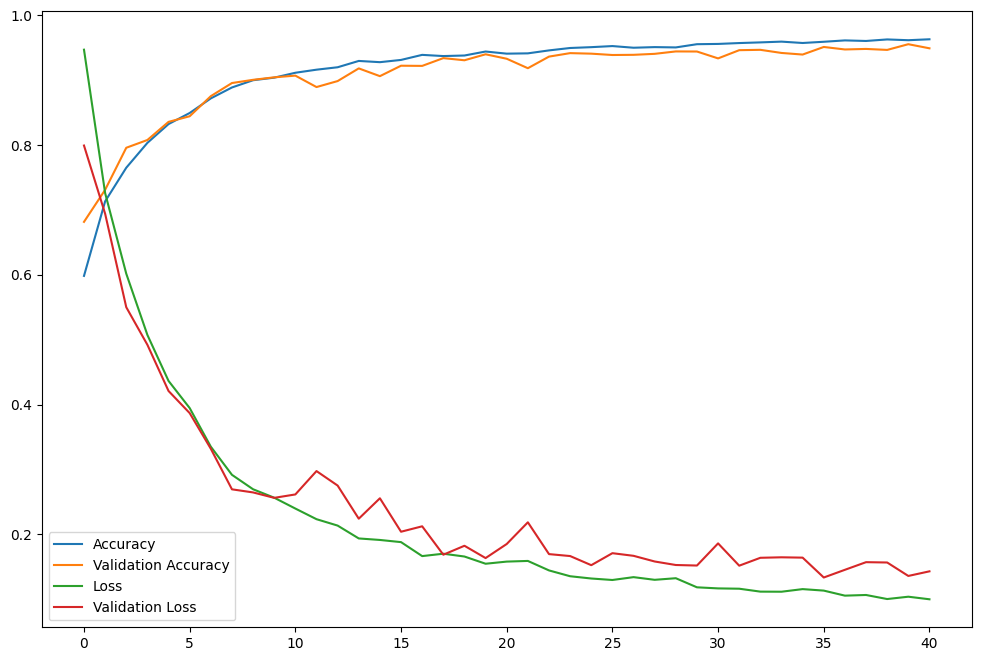

In [44]:
plt.figure(figsize=(12, 8))
plt.plot(history['accuracy'], label='Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.plot(history['loss'], label='Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()

In [45]:
gru_model.load_state_dict(torch.load("/content/best_model.pth"))

# Define the function to calculate accuracy
def calculate_accuracy(predictions, targets):
    _, predicted = torch.max(predictions, 1)
    correct = torch.eq(predicted, targets).sum().item()
    total = targets.size(0)
    accuracy = correct / total
    return accuracy

all_pred = []
all_labels = []

gru_model.eval()  # Set the model to evaluation mode
m = nn.Softmax(dim=1)
with torch.no_grad():
    test_accuracy = []
    with tqdm(total=len(test_dataloader), desc = 'Testing') as pbar:
      for data in test_dataloader:
          inputs, labels = data
          outputs = gru_model(inputs)
          all_pred.extend(np.asarray(m(outputs.cpu().data)))
          all_labels.extend(torch.max(labels, 1)[1])
          test_accuracy.append(calculate_accuracy(outputs, torch.max(labels, 1)[1]))
          pbar.update(1)

all_labels = np.asarray([int(x) for x in all_labels])
predicted = np.argmax(all_pred, axis=1)

precision = precision_score(all_labels, predicted, average='weighted')
recall = recall_score(all_labels, predicted, average='weighted')
f1 = f1_score(all_labels, predicted, average='weighted')

cm = confusion_matrix(all_labels, predicted)

# Get the TP, TN, FP, FN values
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

macro_roc_auc_ovo = roc_auc_score(all_labels, all_pred, multi_class="ovo", average="macro")

print(f'Loss: {history["val_loss"][-1]:.4f}')
print(f'Accuracy: {np.mean(test_accuracy):.4f}')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("TP:", TP.sum())
print("TN:", TN.sum())
print("FP:", FP.sum())
print("FN:", FN.sum())
print("AUC:", macro_roc_auc_ovo)
print(f"CPU Usage: {end_cpu_usage - start_cpu_usage}%")
print(f"Memory Usage: {end_memory_usage - start_memory_usage}%")
if len(GPUtil.getGPUs()) != 0: print(f"GPU Usage: {end_gpu_usage - start_gpu_usage}%")
print(f"Execution Time: {execution_time} seconds")

Testing:   0%|          | 0/227 [00:00<?, ?it/s]

Loss: 0.1429
Accuracy: 0.9577
Precision: 0.9587323374667012
Recall: 0.9577309651659094
F1 Score: 0.9579641048178308
TP: 6956
TN: 21482
FP: 307
FN: 307
AUC: 0.9974836877273351
CPU Usage: 49.3%
Memory Usage: 0.0%
GPU Usage: 38.0%
Execution Time: 289.5978696346283 seconds


Text(0.5, 1.0, 'Confusion Matrix')

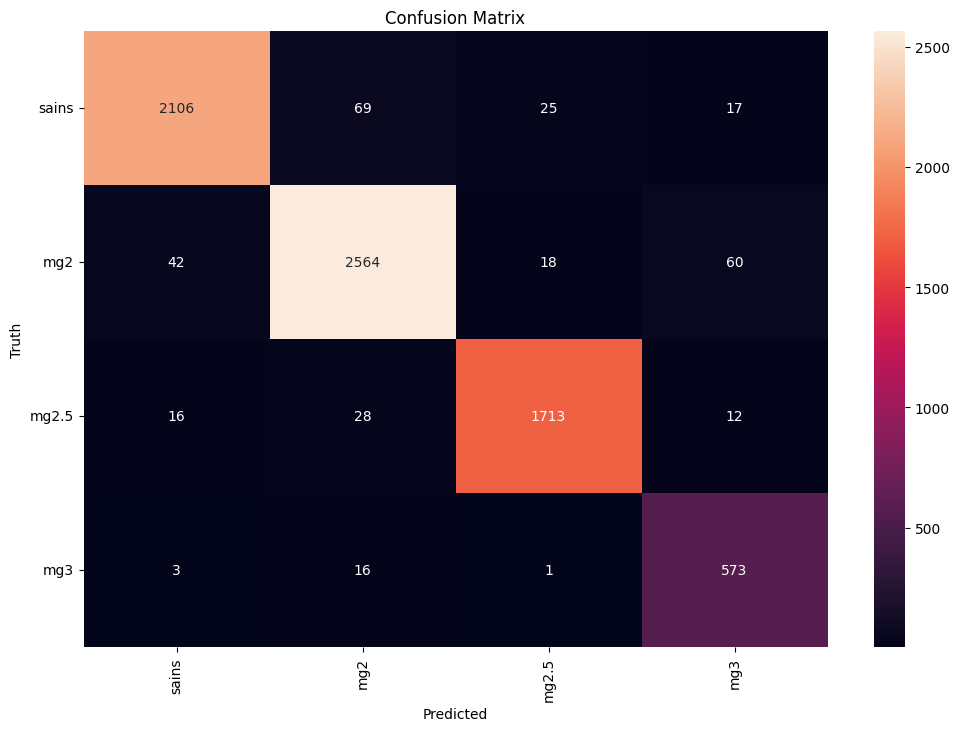

In [46]:
cm = confusion_matrix(all_labels, predicted)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xticks(np.arange(4)+0.5, ['sains', 'mg2', 'mg2.5', 'mg3'], rotation=90)
plt.yticks(np.arange(4)+0.5, ['sains', 'mg2', 'mg2.5', 'mg3'], rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion Matrix")

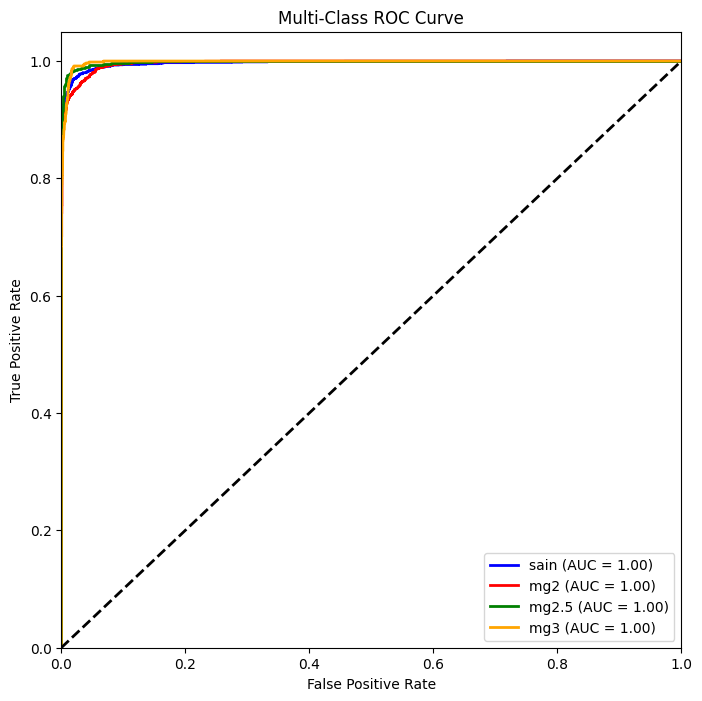

In [47]:
from sklearn.preprocessing import label_binarize

# Binarize the labels
y_bin = label_binarize(all_labels, classes=np.unique(y_multi_class))

# Compute the predicted probabilities for each class
y_prob = np.asarray(all_pred)

# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_multi_class))):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']
classes = ['sain', 'mg2', 'mg2.5', 'mg3']
for i in range(len(np.unique(y_multi_class))):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label='{0} (AUC = {1:.2f})'.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()